In [1]:
#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#imports for user defined functions
from env import host, user, password, get_db_url
import wrangle as wr

# Imports for arithmetic calculations and data frame manipulation
import math
import numpy as np
import pandas as pd

#Imports for statistical analysis
from scipy import stats
import statistics

#imports for splitting data and imputing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

#import for scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

#Imports for creating visualizations
import matplotlib.pyplot as plt 
import seaborn as sns

# 1. Applying scalers to zillow data and visualizing

### Acquire Zillow Data

Using cached csv...


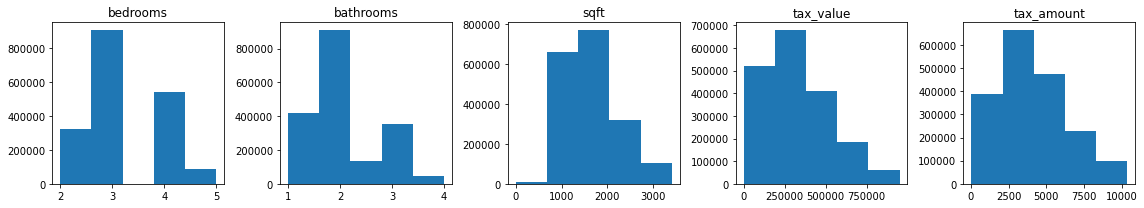

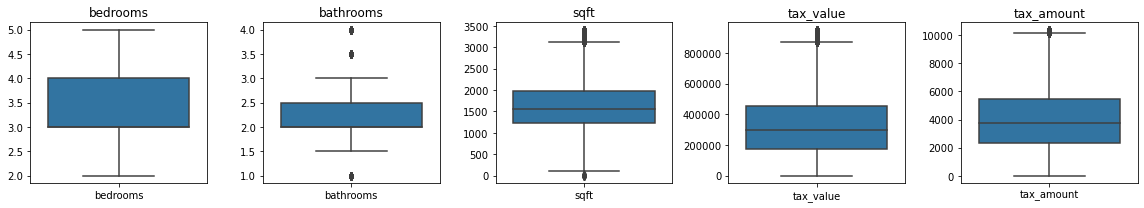

In [4]:
# Acquire cleaned and prepped zillow data using my predefined function
train, validate, test = wr.wrangle_zillow()

In [5]:
#sanity checks 
train.shape, validate.shape, test.shape

((1038959, 7), (445269, 7), (371057, 7))

In [6]:
train.head()

,bedrooms,bathrooms,sqft,tax_value,year_built,tax_amount,fips
10057,4.0,2.0,1561.0,248240.0,1973.0,2504.40,6059.0
2004970,3.0,2.0,1770.0,88390.0,1960.0,1671.93,6037.0
306031,2.0,1.0,1452.0,81169.0,1946.0,1310.88,6037.0
1038595,3.0,1.0,1000.0,119174.0,1950.0,1900.28,6037.0
270959,3.0,2.0,1974.0,432268.0,1988.0,5315.27,6037.0


### Scale and visualize data

In [7]:
def visualize_scaler(scaler, df, target_columns, bins=10):
    fig, axs = plt.subplots(len(target_columns), 2, figsize=(16, 9))
    df_scaled = df.copy()
    df_scaled[target_columns] = scaler.fit_transform(df[target_columns])
    for (ax1, ax2), col in zip(axs, target_columns):
        ax1.hist(df[col], bins=bins)
        ax1.set(title=f'{col} before scaling', xlabel=col, ylabel='count')
        ax2.hist(df_scaled[col], bins=bins)
        ax2.set(title=f'{col} after scaling with {scaler.__class__.__name__}', xlabel=col, ylabel='count')
    plt.tight_layout()
    return fig, axs


(<Figure size 1152x648 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'bedrooms before scaling'}, xlabel='bedrooms', ylabel='count'>,
         <AxesSubplot:title={'center':'bedrooms after scaling with MinMaxScaler'}, xlabel='bedrooms', ylabel='count'>],
        [<AxesSubplot:title={'center':'bathrooms before scaling'}, xlabel='bathrooms', ylabel='count'>,
         <AxesSubplot:title={'center':'bathrooms after scaling with MinMaxScaler'}, xlabel='bathrooms', ylabel='count'>],
        [<AxesSubplot:title={'center':'sqft before scaling'}, xlabel='sqft', ylabel='count'>,
         <AxesSubplot:title={'center':'sqft after scaling with MinMaxScaler'}, xlabel='sqft', ylabel='count'>]],
       dtype=object))

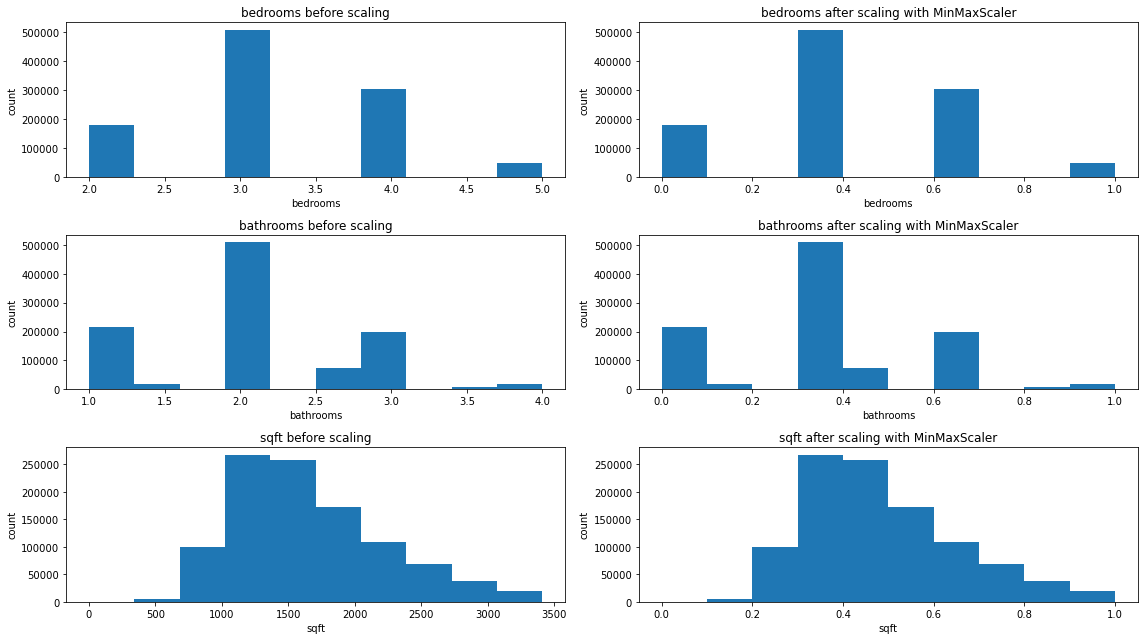

In [10]:
visualize_scaler(scaler=MinMaxScaler(), df=train, target_columns = ['bedrooms', 'bathrooms', 'sqft'])

(<Figure size 1152x648 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'tax_value before scaling'}, xlabel='tax_value', ylabel='count'>,
         <AxesSubplot:title={'center':'tax_value after scaling with MinMaxScaler'}, xlabel='tax_value', ylabel='count'>],
        [<AxesSubplot:title={'center':'tax_amount before scaling'}, xlabel='tax_amount', ylabel='count'>,
         <AxesSubplot:title={'center':'tax_amount after scaling with MinMaxScaler'}, xlabel='tax_amount', ylabel='count'>]],
       dtype=object))

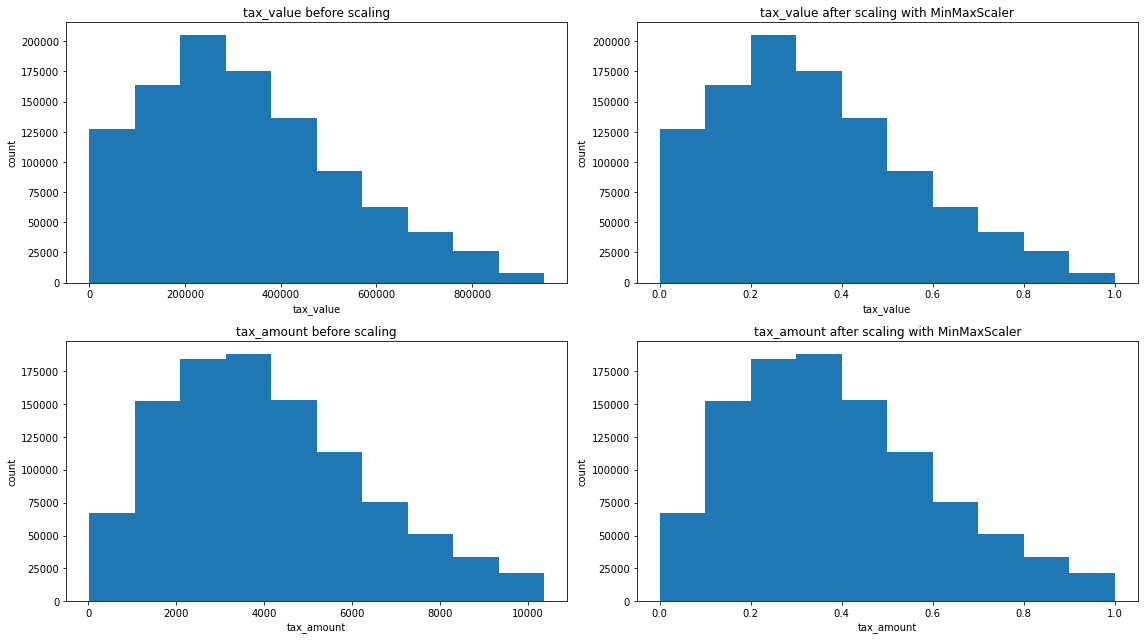

In [11]:
visualize_scaler(scaler=MinMaxScaler(), df=train, target_columns = ['tax_value', 'tax_amount'])

# 2. Apply the .inverse_transform method to scaled data
### - Is the resulting dataset the exact same as the orginial data?

In [14]:
# Create list of my target columns
cols = ['bedrooms', 'bathrooms', 'sqft', 'tax_value', 'tax_amount']

# Create a data frame with unscaled data containing target columns
original_data = train[cols]
original_data.head()

,bedrooms,bathrooms,sqft,tax_value,tax_amount
10057,4.0,2.0,1561.0,248240.0,2504.40
2004970,3.0,2.0,1770.0,88390.0,1671.93
306031,2.0,1.0,1452.0,81169.0,1310.88
1038595,3.0,1.0,1000.0,119174.0,1900.28
270959,3.0,2.0,1974.0,432268.0,5315.27


In [15]:
# Construct the scalers
minmaxscaler = MinMaxScaler()
standardscaler = StandardScaler()
robustscaler = RobustScaler()

# Fit the scalers
minmaxscaler.fit(train[cols])
standardscaler.fit(train[cols])
robustscaler.fit(train[cols])

RobustScaler()

In [16]:
# Scale the train data set

scaled_minmax = minmaxscaler.transform(train[cols])
scaled_standard = standardscaler.transform(train[cols])
scaled_robust = robustscaler.transform(train[cols])

In [17]:
# Apply the .inverse_transform to the scaled data and check if it is same as original

(minmaxscaler.inverse_transform(scaled_minmax) == original_data).all()

bedrooms       True
bathrooms     False
sqft          False
tax_value     False
tax_amount    False
dtype: bool

In [19]:
# Apply the .inverse_transform to the scaled data and check if it is same as original

(standardscaler.inverse_transform(scaled_standard) == original_data).all()

bedrooms       True
bathrooms      True
sqft          False
tax_value     False
tax_amount    False
dtype: bool

In [20]:
# Apply the .inverse_transform to the scaled data and check if it is same as original

(robustscaler.inverse_transform(scaled_robust) == original_data).all()

bedrooms       True
bathrooms      True
sqft          False
tax_value     False
tax_amount    False
dtype: bool

Takeways:

- The scaled data with inverse_transform is not exactly the same as original data set for most columns
- The data was exactly the same for bedrooms, bathrooms using a stard and robust scaler
 - This may be because these two columns contain mostly whole numbers/intergers rather than floats

# 3. Read documentation for QuantileTransformer.
### - Use normal for the output_distribution and apply this scaler to your data then visualize.

(<Figure size 1152x648 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'bedrooms before scaling'}, xlabel='bedrooms', ylabel='count'>,
         <AxesSubplot:title={'center':'bedrooms after scaling with QuantileTransformer'}, xlabel='bedrooms', ylabel='count'>],
        [<AxesSubplot:title={'center':'bathrooms before scaling'}, xlabel='bathrooms', ylabel='count'>,
         <AxesSubplot:title={'center':'bathrooms after scaling with QuantileTransformer'}, xlabel='bathrooms', ylabel='count'>],
        [<AxesSubplot:title={'center':'sqft before scaling'}, xlabel='sqft', ylabel='count'>,
         <AxesSubplot:title={'center':'sqft after scaling with QuantileTransformer'}, xlabel='sqft', ylabel='count'>]],
       dtype=object))

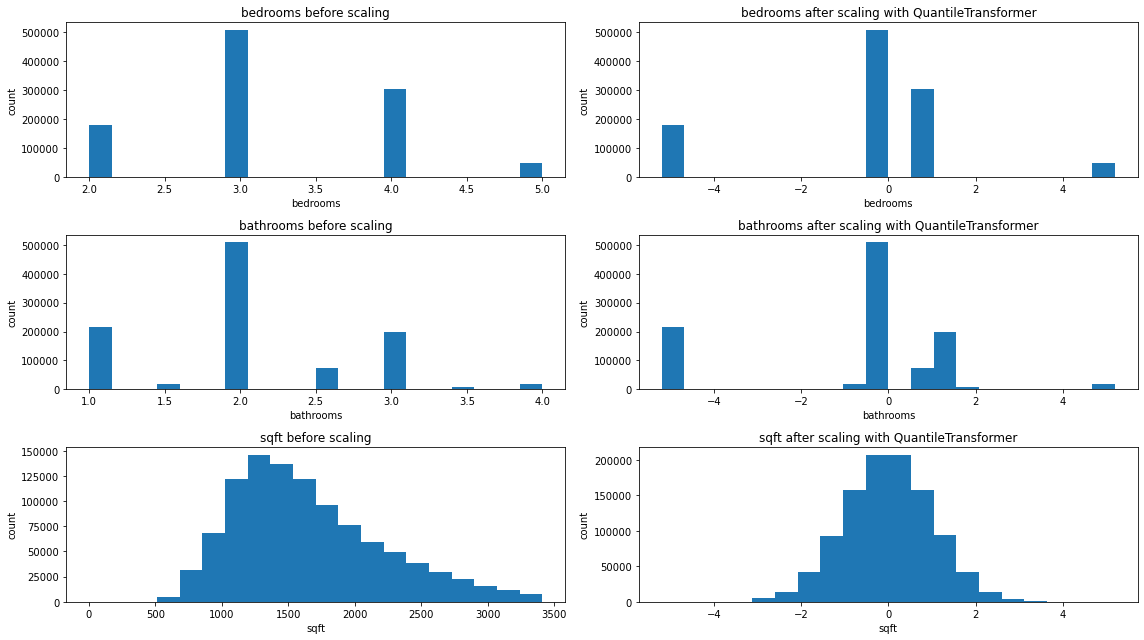

In [21]:
visualize_scaler(
    scaler=QuantileTransformer(output_distribution='normal'),
    df=train,
    target_columns=['bedrooms', 'bathrooms', 'sqft'],
    bins=20,
)

(<Figure size 1152x648 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'tax_value before scaling'}, xlabel='tax_value', ylabel='count'>,
         <AxesSubplot:title={'center':'tax_value after scaling with QuantileTransformer'}, xlabel='tax_value', ylabel='count'>],
        [<AxesSubplot:title={'center':'tax_amount before scaling'}, xlabel='tax_amount', ylabel='count'>,
         <AxesSubplot:title={'center':'tax_amount after scaling with QuantileTransformer'}, xlabel='tax_amount', ylabel='count'>]],
       dtype=object))

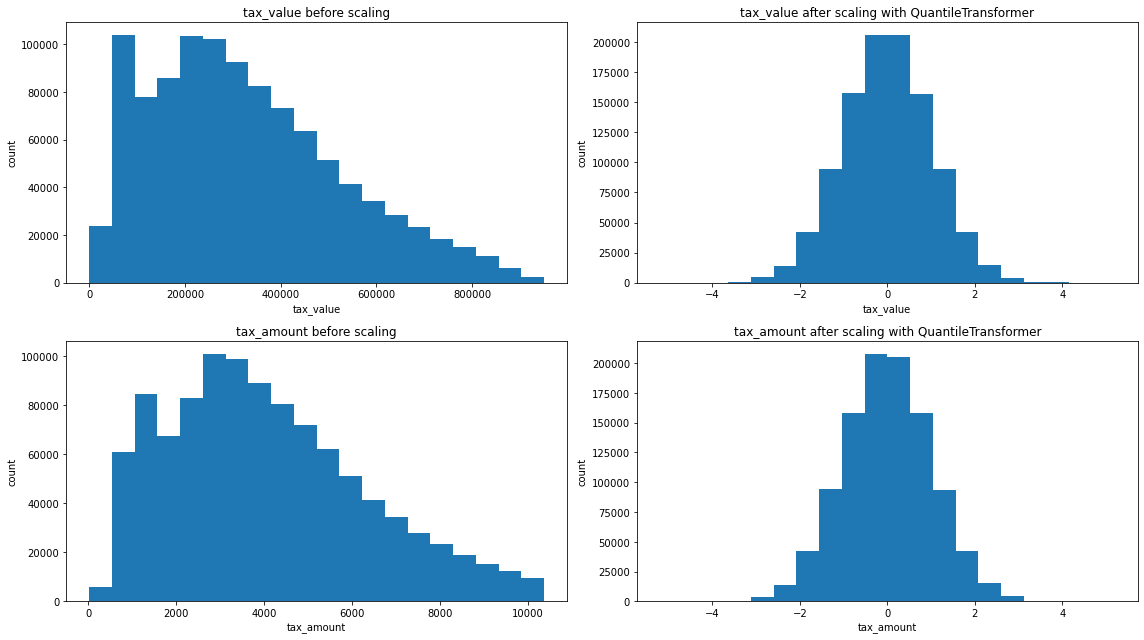

In [22]:
visualize_scaler(
    scaler=QuantileTransformer(output_distribution='normal'),
    df=train,
    target_columns=['tax_value', 'tax_amount'],
    bins=20,
)

# 4. Use the QuantileTransformer, but omit the output_distribution argument.
### - Visualize your results. What do you notice?

(<Figure size 1152x648 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'bedrooms before scaling'}, xlabel='bedrooms', ylabel='count'>,
         <AxesSubplot:title={'center':'bedrooms after scaling with QuantileTransformer'}, xlabel='bedrooms', ylabel='count'>],
        [<AxesSubplot:title={'center':'bathrooms before scaling'}, xlabel='bathrooms', ylabel='count'>,
         <AxesSubplot:title={'center':'bathrooms after scaling with QuantileTransformer'}, xlabel='bathrooms', ylabel='count'>],
        [<AxesSubplot:title={'center':'sqft before scaling'}, xlabel='sqft', ylabel='count'>,
         <AxesSubplot:title={'center':'sqft after scaling with QuantileTransformer'}, xlabel='sqft', ylabel='count'>]],
       dtype=object))

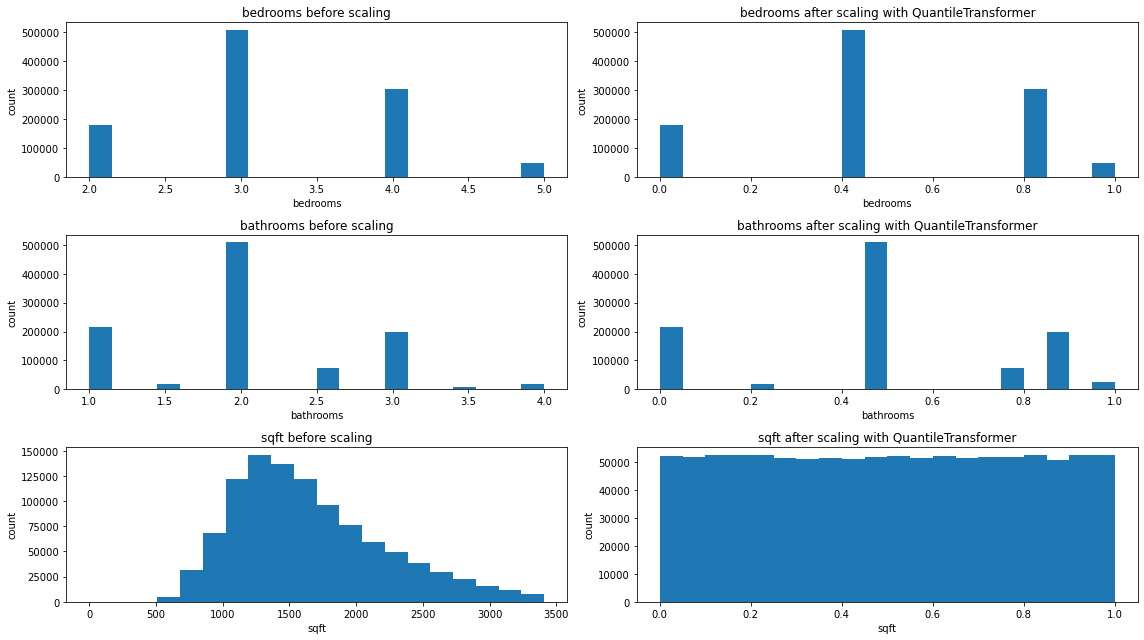

In [24]:
visualize_scaler(
    scaler=QuantileTransformer(),
    df=train,
    target_columns=['bedrooms', 'bathrooms', 'sqft'],
    bins=20,
)

*The sqft is unreadable here after scaling.*

(<Figure size 1152x648 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'tax_value before scaling'}, xlabel='tax_value', ylabel='count'>,
         <AxesSubplot:title={'center':'tax_value after scaling with QuantileTransformer'}, xlabel='tax_value', ylabel='count'>],
        [<AxesSubplot:title={'center':'tax_amount before scaling'}, xlabel='tax_amount', ylabel='count'>,
         <AxesSubplot:title={'center':'tax_amount after scaling with QuantileTransformer'}, xlabel='tax_amount', ylabel='count'>]],
       dtype=object))

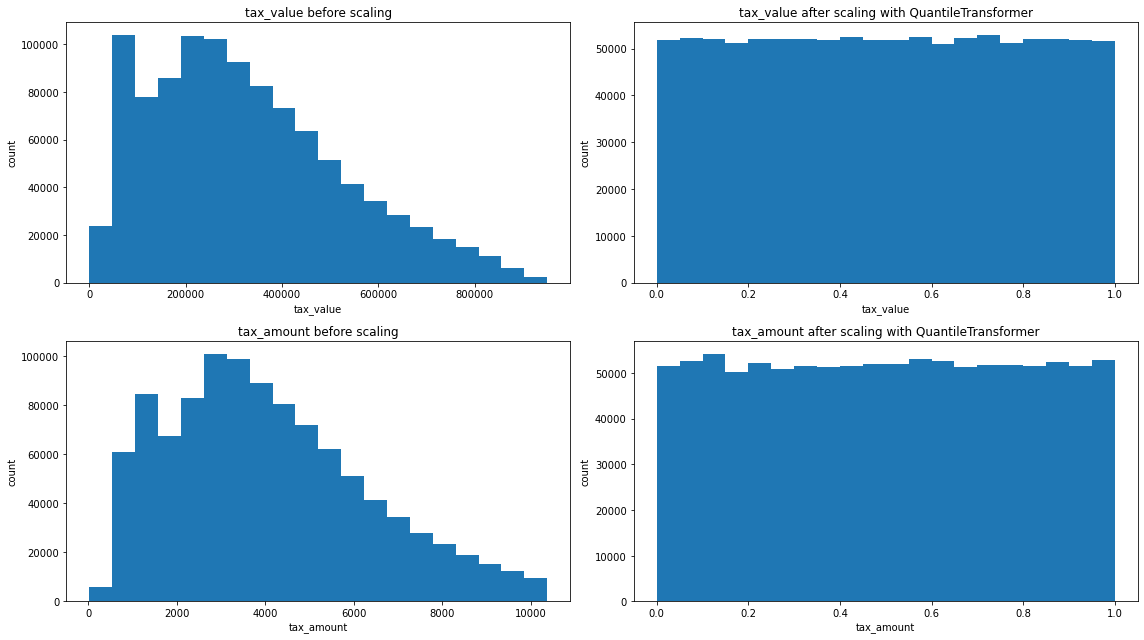

In [25]:
visualize_scaler(
    scaler=QuantileTransformer(),
    df=train,
    target_columns=['tax_value', 'tax_amount'],
    bins=20,
)

*Scaling makes the data distribution unreadable.*

# 5.  Choose a scaling method for your dataset. 
### - Write a function within your prepare.py that accepts as input the train, validate, and test data splits, and returns the scaled versions of each.

In [26]:
def scale_data(train, validate, test, return_scaler=False):
    '''
    Scales the 3 data splits.
    
    takes in the train, validate, and test data splits and returns their scaled counterparts.
    
    If return_scaler is true, the scaler object will be returned as well.
    '''
    columns_to_scale = ['bedrooms', 'bathrooms', 'tax_value', 'tax_amount', 'sqft']
    
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    scaler = MinMaxScaler()
    scaler.fit(train[columns_to_scale])
    
    train_scaled[columns_to_scale] = scaler.transform(train[columns_to_scale])
    validate_scaled[columns_to_scale] = scaler.transform(validate[columns_to_scale])
    test_scaled[columns_to_scale] = scaler.transform(test[columns_to_scale])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [28]:
# test out the function 
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test)

In [29]:
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((1038959, 7), (445269, 7), (371057, 7))

In [31]:
train.head()

,bedrooms,bathrooms,sqft,tax_value,year_built,tax_amount,fips
10057,4.0,2.0,1561.0,248240.0,1973.0,2504.40,6059.0
2004970,3.0,2.0,1770.0,88390.0,1960.0,1671.93,6037.0
306031,2.0,1.0,1452.0,81169.0,1946.0,1310.88,6037.0
1038595,3.0,1.0,1000.0,119174.0,1950.0,1900.28,6037.0
270959,3.0,2.0,1974.0,432268.0,1988.0,5315.27,6037.0


In [32]:
train_scaled.head()

,bedrooms,bathrooms,sqft,tax_value,year_built,tax_amount,fips
10057,0.666667,0.333333,0.457612,0.261030,1973.0,0.239843,6059.0
2004970,0.333333,0.333333,0.518921,0.092929,1960.0,0.159469,6037.0
306031,0.000000,0.000000,0.425638,0.085335,1946.0,0.124610,6037.0
1038595,0.333333,0.000000,0.293048,0.125302,1950.0,0.181516,6037.0
270959,0.333333,0.333333,0.578762,0.454557,1988.0,0.511229,6037.0
